#02. Neural network classification with pytorch

classification is a proplem of predicting whether something is one thing or other or ...

##1. Make classification data and get it ready

pytorch focused on deep learning, sklearn on broader machine learning concepts

In [ ]:
import sklearn

In [9]:
from sklearn.datasets import make_circles

#make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [10]:
import pandas as pd
circles = pd.DataFrame({"x1": X[: , 0],
                       "x2": X[: , 1],
                       "label": y}
                       )

circles.head(5)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [11]:
len(X), len(y), X[:5],y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

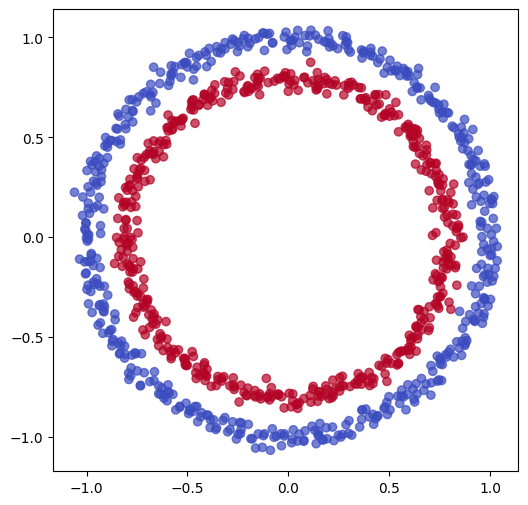

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.coolwarm,
            alpha=0.7)
plt.show()

**Note:** this is called toy dataset. small enough to experiment, but sizeable enough for learning fundementals.

##turning data into tensors
check input and output

In [13]:
X.shape, y.shape

((1000, 2), (1000,))

In [14]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [15]:
#view the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"values of one sample of x: {X_sample} and one value of y: {y_sample}")
print(f"shape of one sample of x: {X_sample.shape} and shape of one sample of y: {y_sample.shape}")

values of one sample of x: [0.75424625 0.23148074] and one value of y: 1
shape of one sample of x: (2,) and shape of one sample of y: ()


In [16]:
#turn data into tensors
import torch
torch.__version__

'2.6.0+cu124'

In [17]:
type(X), type(y), X.dtype, y.dtype

(numpy.ndarray, numpy.ndarray, dtype('float64'), dtype('int64'))

In [18]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #20%test size
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test),

(800, 200, 800, 200)

##building model for classification

1. agonestic device
2. construct model(nn.Module)
3. loss & optimizer
4. training & testing loops

In [21]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available else "cpu"

In [22]:
device, X.device, y.device

('cuda', device(type='cpu'), device(type='cpu'))

In [23]:
X_train.device

device(type='cpu')

after we setup agonestic code, we create a model:

1. subclass 'nn.Module' (almost all models in pytorch subclass 'nn.Module')
2. create 2 'nn.linear()' layers that are capable of handling our data
3. define a 'forward()' method for forward pass of model
4. initiate an instance of our model and target 'device'

In [24]:
#construct model subclass nn.Module
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    #creating nn.linear to handle our data
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features= 5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  #forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x -> layer_1 -> layer_2 -> output

#4. initiate instance of our model & send to target device
model_0 = CircleModelv0().to(device)
model_0


CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
device

'cuda'

In [26]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [27]:
##nn.sequential
torch.manual_seed(42)
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features= 5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('1.bias', tensor([-0.2060], device='cuda:0'))])

In [29]:
#make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}\n")
print(f"length of test sample: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])

length of test sample: 200, shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [30]:
#regression: MAE, MSE | CLASSIFICATION: BCE, CE
loss_fn = nn.BCEWithLogitsLoss() #w/ sigmoid activation
#loss_fn = nn.BCELoss() dont have activation function so need to include sigmoid b/w layers sequential -> sigmoid ->

#loss with logit more numerically stable & expect o/p as logit, but loss fn w/o logit expect pred prob as o/p

 #optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr = 0.1)

In [31]:
#calculate accuracy - how many correct 0 and 1?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))
  return acc

##3. training model

training loop:
forward -> loss -> zero -> backward -> step (grad desc)

GOING from raw logits -> prediction probabilities -> prediction labels

we convert logits into prediction probabilities by activation like sigmoid/softmax.

by rouding probabilities or ... we can convert them to labels.



In [32]:
#view the first 5 outputs of forward pass
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits, y_test[:5]

(tensor([[-0.1269],
         [-0.0967],
         [-0.1908],
         [-0.1089],
         [-0.1667]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [33]:
#use sigmoid activation on our model logits to turn them into probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

for prediction prob we need to perform range-style rounding on them:

y_pred_probs > 0.5 class 1  

y_pred_probs < 0.5 class 0

In [34]:
#now probs to labels using round
y_preds = torch.round(y_pred_probs)

#in full logits -> probs -> labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

#rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [35]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [36]:
#training loop
#reproducability
torch.cuda.manual_seed(42)
epoches = 200

#put data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#build training loop
for epoch in range(epoches):
  model_0.train() #training

  y_logits = model_0(X_train).squeeze() #forward pass\
  y_pred = torch.round(torch.sigmoid(y_logits))

  #calculate loss & acc
  loss = loss_fn(y_logits,  #logits cuz loss is nn.BCEWithLogitsLoss()
                 y_train)#if nn.BCELoss we use loss = loss_fn(torch.sigmoid(y_logits))
  acc = accuracy_fn(y_true = y_train,
                    y_pred= y_pred)

  optimizer.zero_grad()

  #backpropagation
  loss.backward()

  #gradient descent
  optimizer.step()


  ###testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred = test_preds)

  #show what is happening
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% ")




Epoch: 0 | Loss: 0.69569 | accuracy: 0.50% | Test loss: 0.69721 | Test accuracy: 0.50% 
Epoch: 20 | Loss: 0.69343 | accuracy: 0.46% | Test loss: 0.69585 | Test accuracy: 0.48% 
Epoch: 40 | Loss: 0.69312 | accuracy: 0.49% | Test loss: 0.69573 | Test accuracy: 0.47% 
Epoch: 60 | Loss: 0.69306 | accuracy: 0.51% | Test loss: 0.69564 | Test accuracy: 0.47% 
Epoch: 80 | Loss: 0.69304 | accuracy: 0.51% | Test loss: 0.69553 | Test accuracy: 0.47% 
Epoch: 100 | Loss: 0.69302 | accuracy: 0.51% | Test loss: 0.69542 | Test accuracy: 0.47% 
Epoch: 120 | Loss: 0.69301 | accuracy: 0.51% | Test loss: 0.69532 | Test accuracy: 0.46% 
Epoch: 140 | Loss: 0.69300 | accuracy: 0.51% | Test loss: 0.69523 | Test accuracy: 0.46% 
Epoch: 160 | Loss: 0.69300 | accuracy: 0.51% | Test loss: 0.69515 | Test accuracy: 0.46% 
Epoch: 180 | Loss: 0.69299 | accuracy: 0.51% | Test loss: 0.69509 | Test accuracy: 0.47% 


##make predictions and evaluate the model
seems like the model does not learn anything

so to inspect -> make some predictions -> **visualize,  visualize, visualize**

to do so, we import function called `plot_decision_boundary()`

In [37]:
import numpy as np

'''import requests
from pathlib import Path

#download helper functions / dowmload if not already downloaded
if Path("helper_functions.py").is_file():
  print("c is already exists, skip download")
else:
  print("download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary'''

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

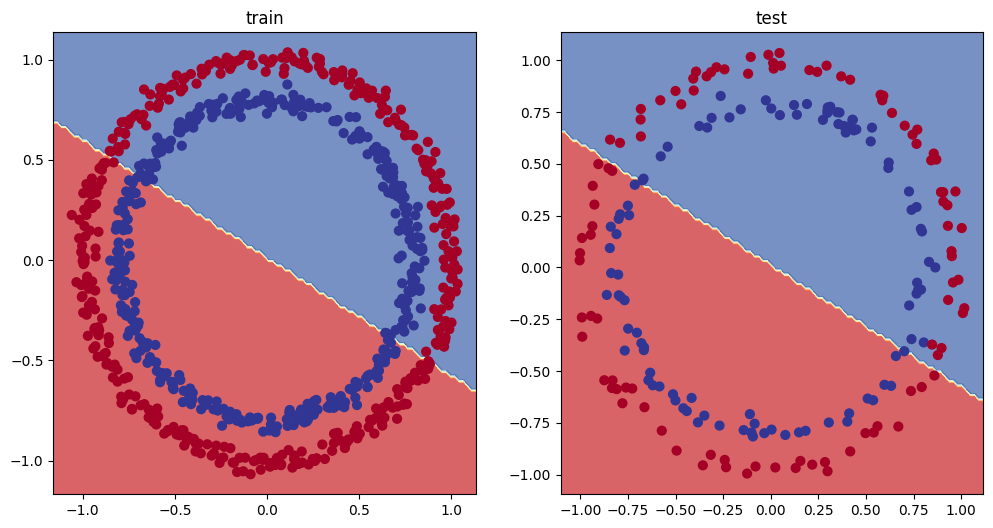

In [38]:
#plot decision boundary of model
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

##How to improve the model???

**add more layers, hidden units, change activation, change learning rate, fit for longer, change loss**

this options are all from model perspective cuz directly deal with model rather than data

we can change hyperparameters: loss, epoch, lr, units...
we cannot change parameters like model.state_dict()

how? change one value at time and track result
1. hidden units 5 -> 10
2. increase number of layers 2 ->3
3. epoches 100 ->1000

In [39]:
class circlemodelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features= 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    #z = self.layer_1(x)
    #z = self.layer_2(x)
    #z = self.layer_3(x)
    return self.layer_3(self.layer_2(self.layer_1(x))) #this way speeds up


#now we create instance
model_1 = circlemodelv1().to(device)
model_1


circlemodelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386],
                      [-0.6007,  0.5459],
                      [ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.1918,  0.2976,  0.6313,  0.4087, -0.3091,  0.4082,  0.1265,  0.3591,
                      -0.4310, -0.7000], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,  0.2475,
                       -0.2247,  0.0199],
                      [-0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874, -0.1886,
                       -0.1886,  0.2844],
                      [ 0.1054,  0.304

In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)


In [42]:
torch.manual_seed(42)
epoches = 1000

#put data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epoches):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_labels = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_labels, y_pred=y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_labels = torch.round(torch.sigmoid(test_logits))
    loss = loss_fn(test_logits, y_test)
    acc = accuracy_fn(y_true=test_labels, y_pred=y_test)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% ")



Epoch: 0 | Loss: 0.70111 | accuracy: 0.53% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 100 | Loss: 0.69443 | accuracy: 0.48% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 200 | Loss: 0.69440 | accuracy: 0.47% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 300 | Loss: 0.69446 | accuracy: 0.46% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 400 | Loss: 0.69451 | accuracy: 0.45% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 500 | Loss: 0.69455 | accuracy: 0.45% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 600 | Loss: 0.69458 | accuracy: 0.45% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 700 | Loss: 0.69460 | accuracy: 0.46% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 800 | Loss: 0.69462 | accuracy: 0.46% | Test loss: 0.69503 | Test accuracy: 0.47% 
Epoch: 900 | Loss: 0.69464 | accuracy: 0.46% | Test loss: 0.69503 | Test accuracy: 0.47% 


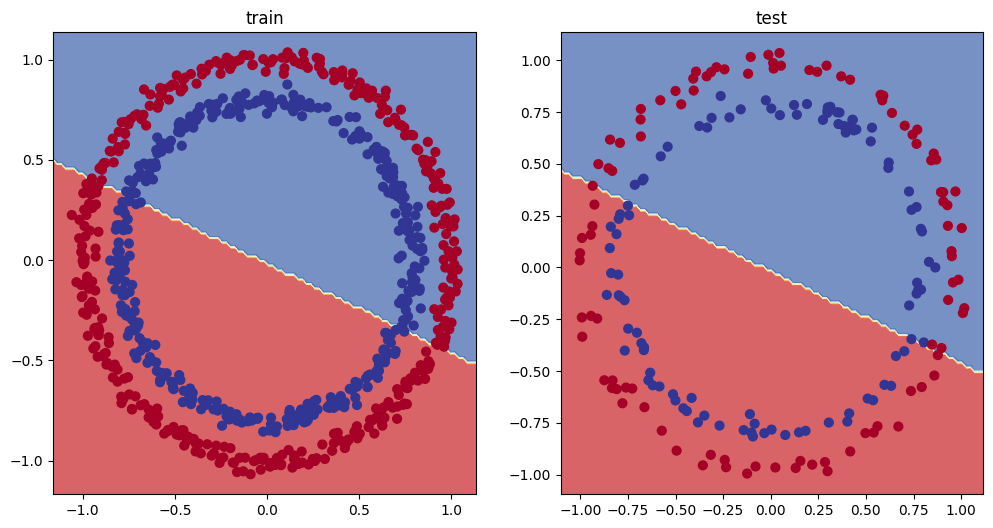

In [43]:
#plot decision boundary of model
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

##preparing data to see if our model can fit a straigt line
One way **to troubleshoot a larger problem is to test out a smaller problem**

In [44]:
#create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

x_regression = torch.arange(start, end, step).unsqueeze(dim = 1)
y_regression = weight * x_regression + bias
print(len(x_regression))
x_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [45]:
#create train and test split
train_split = int(0.8 * len(x_regression))
x_train_req, y_train_req = x_regression[:train_split], y_regression[:train_split]
x_test_req, y_test_req = x_regression[train_split:], y_regression[train_split:]
len(x_train_req), len(y_train_req), len(x_test_req), len(y_test_req)

(80, 80, 20, 20)

In [46]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


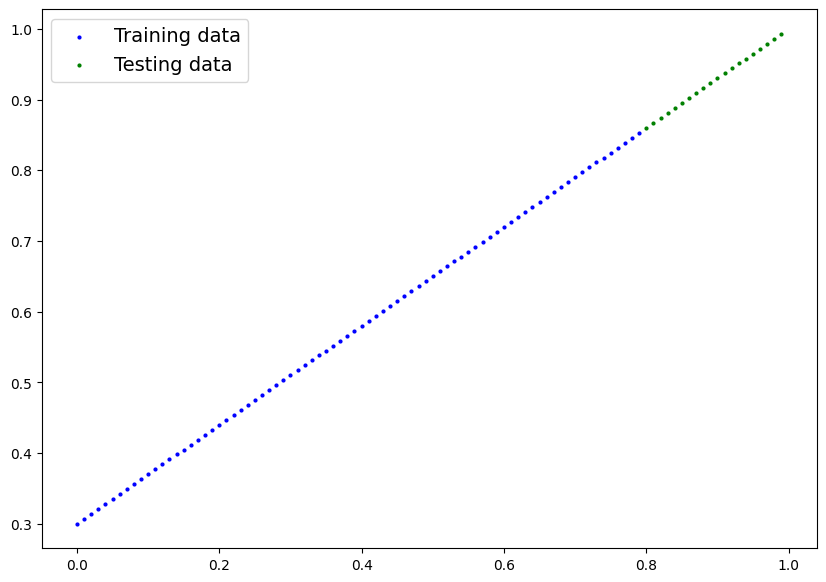

In [47]:
plot_predictions(
    train_data=x_train_req,
    train_labels=y_train_req,
    test_data=x_test_req,
    test_labels=y_test_req)

##adjucting `model_1` to fit a straight line

In [48]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
#loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoches = 2000
x_train_req, y_train_req = x_train_req.to(device), y_train_req.to(device)
x_test_req, y_test_req = x_test_req.to(device), y_test_req.to(device)

for epoch in range(epoches):
  model_2.train()
  y_pred_req = model_2(x_train_req)
  loss = loss_fn(y_pred_req, y_train_req)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(x_test_req)
    test_loss = loss_fn(test_pred, y_test_req)

  if epoch % 100 == 0:
    print(f"epoch: {epoch} | loss: {loss} | test loss: { test_loss}")

epoch: 0 | loss: 0.7598585486412048 | test loss: 0.541427731513977
epoch: 100 | loss: 0.09308692812919617 | test loss: 0.029011724516749382
epoch: 200 | loss: 0.07375659793615341 | test loss: 0.028500476852059364
epoch: 300 | loss: 0.06745029240846634 | test loss: 0.0061517744325101376
epoch: 400 | loss: 0.06106658652424812 | test loss: 0.020038655027747154
epoch: 500 | loss: 0.05698131397366524 | test loss: 0.010606971569359303
epoch: 600 | loss: 0.0485655702650547 | test loss: 0.013262957334518433
epoch: 700 | loss: 0.06108519434928894 | test loss: 0.021267009899020195
epoch: 800 | loss: 0.05599264055490494 | test loss: 0.014256960712373257
epoch: 900 | loss: 0.055710047483444214 | test loss: 0.006033757235854864
epoch: 1000 | loss: 0.06466340273618698 | test loss: 0.025981277227401733
epoch: 1100 | loss: 0.05517693981528282 | test loss: 0.006787893362343311
epoch: 1200 | loss: 0.07117106020450592 | test loss: 0.01923050358891487
epoch: 1300 | loss: 0.05286625772714615 | test loss: 0

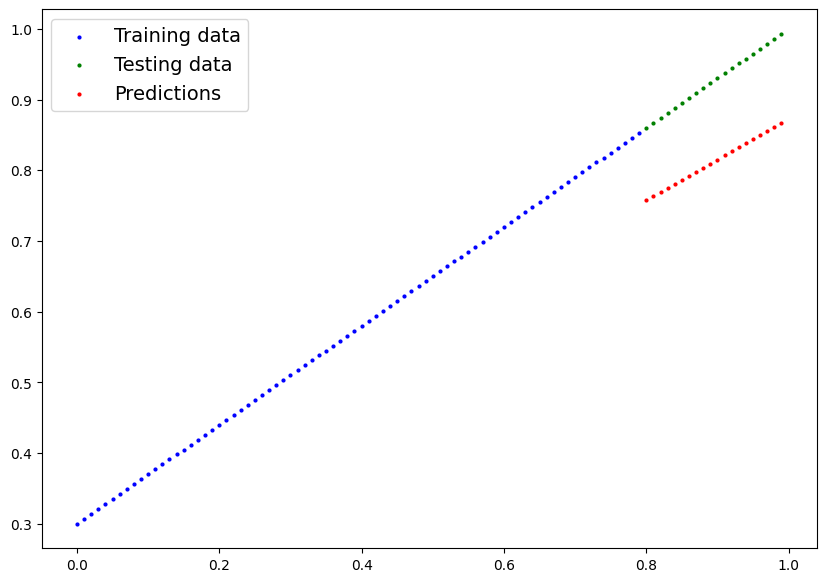

In [51]:
model_2.eval()
with torch.inference_mode():
  y_pred = model_2(x_test_req)
plot_predictions(
    train_data=x_train_req.cpu(),
    train_labels=y_train_req.cpu(),
    test_data=x_test_req.cpu(),
    test_labels=y_test_req.cpu(),
    predictions=y_pred.cpu())


##6. missing piece of our model: non-linearity

what Patterns could you draw, if given infinte straight and non_straight lines?
in terms of ml, infinite (but actually finite) of linear and non_linear functions?

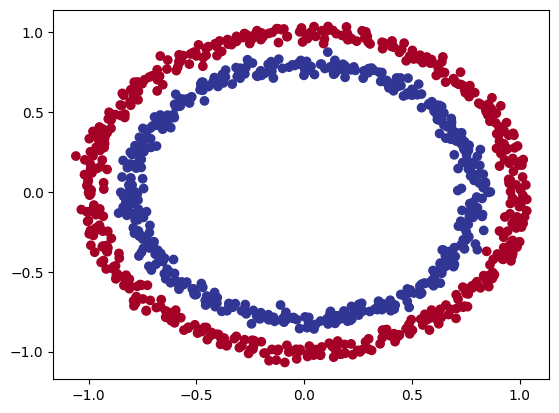

In [52]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [53]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

##6.2 building a model with non_linearity
ANN is combination b/w linear & non-linear fns

In [54]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [55]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_3.parameters(),
                            lr=0.1)

In [56]:
len(X_test)

200

In [57]:
###6.3 training a model w/ non-linearity
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoches = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ###Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)


  #print what is happening
  if epoch % 100 == 0:
    print(f"epoch: {epoch} | loss: {loss:.4f} | acc: {acc:.2f}% | test loss: {test_loss:.4} | test acc: {test_acc:.2f}%")

epoch: 0 | loss: 0.6948 | acc: 0.44% | test loss: 0.6952 | test acc: 0.47%
epoch: 100 | loss: 0.6912 | acc: 0.58% | test loss: 0.692 | test acc: 0.54%
epoch: 200 | loss: 0.6889 | acc: 0.54% | test loss: 0.6892 | test acc: 0.54%
epoch: 300 | loss: 0.6855 | acc: 0.61% | test loss: 0.6855 | test acc: 0.65%
epoch: 400 | loss: 0.6792 | acc: 0.67% | test loss: 0.6792 | test acc: 0.69%
epoch: 500 | loss: 0.6676 | acc: 0.69% | test loss: 0.6683 | test acc: 0.73%
epoch: 600 | loss: 0.6441 | acc: 0.80% | test loss: 0.6476 | test acc: 0.80%
epoch: 700 | loss: 0.5927 | acc: 0.93% | test loss: 0.604 | test acc: 0.92%
epoch: 800 | loss: 0.4895 | acc: 0.98% | test loss: 0.5128 | test acc: 0.97%
epoch: 900 | loss: 0.3326 | acc: 0.99% | test loss: 0.3663 | test acc: 0.99%


##6.4 evaluating a model trained with non-linear activation

In [58]:
#make predictions
model_3.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

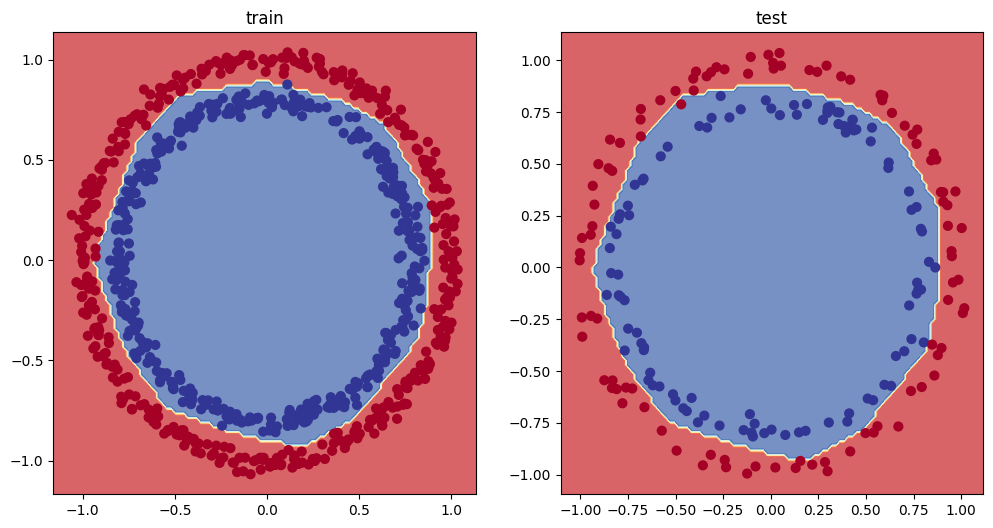

In [59]:
#plot predictions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

##7. Replicating non-linear activation functions
neural networks rather than us telling the model what to learn, we give it the tools to discover patterns in data.
these tools are linear and non-linear functions

In [60]:
#create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype, A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

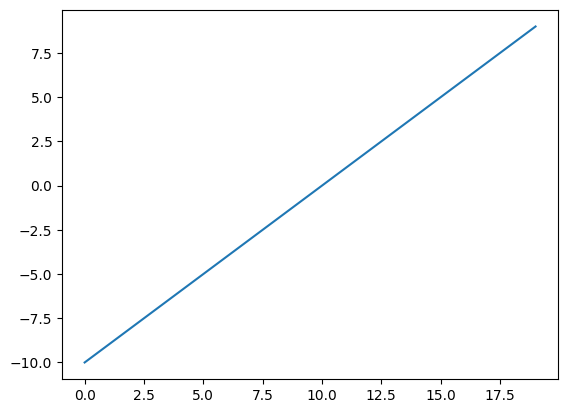

In [61]:
#visual the tensor
plt.plot(A)

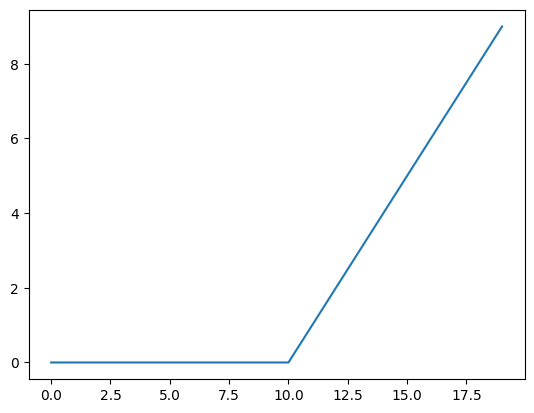

In [62]:
plt.plot(torch.relu(A))

In [63]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [64]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

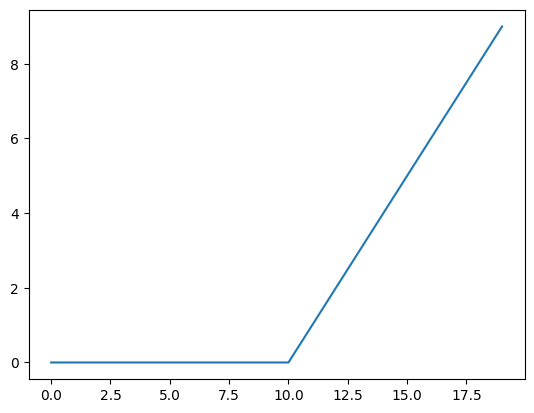

In [65]:
plt.plot(relu(A))

In [66]:
#NOW sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

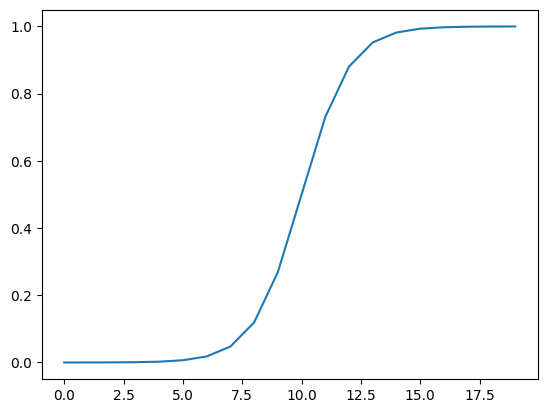

In [67]:
plt.plot(sigmoid(A))

##8. puttting it all together w/ multiclass classification

800 200 800 200 tensor([[ 5,  3],
        [-2,  9],
        [-8, -9],
        [-6, -4],
        [-3,  7]]) tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])


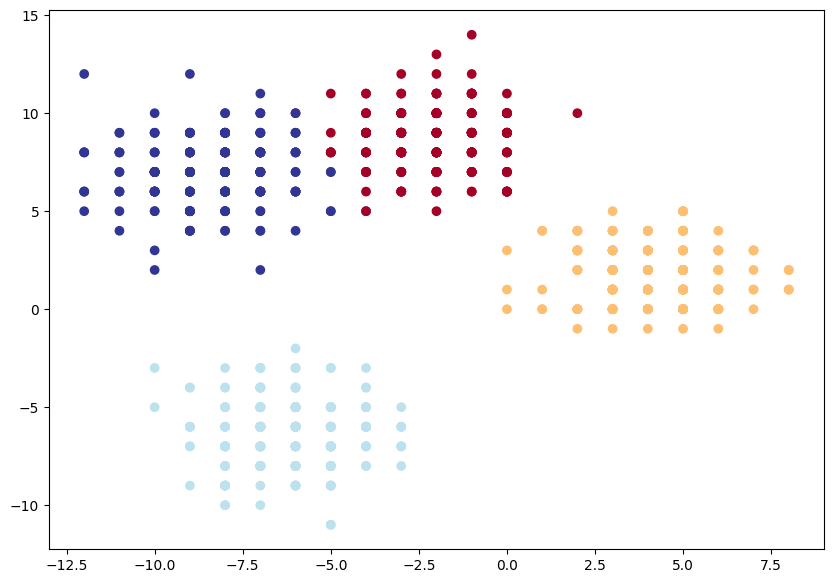

In [68]:
#creating a toy multiclass dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creations
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.long)
y_blob = torch.from_numpy(y_blob).type(torch.long)

#split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)


print(len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test), X_blob_train[:5], y_blob_train[:10])

#visualize visualize visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


##multiclass classification model

In [69]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [70]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [71]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    '''initialize multiclass classification model

    args:
      input_features (int): no. of input features
      output_features (int): no. of output features
      hidden_units (int): no. of hidden units b/w layers, default 8

      example:
      '''

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#create instance of model
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [76]:
#getting raw predictions of model
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_train.to(device).float())

y_preds[:10]

tensor([[-0.7328, -0.6674, -1.4720, -1.0784],
        [-0.2140, -1.1759, -0.9279, -0.2747],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2323, -0.2560,  0.1311,  0.0297],
        [-0.1109, -0.9566, -0.6688, -0.1868],
        [-0.1394, -1.0029, -0.7756, -0.2462],
        [-0.2110, -1.1757, -0.9048, -0.2567],
        [-0.3602, -0.5076, -0.8552, -0.6925],
        [-0.0168, -0.7658, -0.4092, -0.0836],
        [-0.1617, -1.0662, -0.7926, -0.2263]], device='cuda:0')

##getting predictions for multiclasss classification

logit -> prob -> label

logit -> softmax -> argmax

In [94]:
print(y_blob_train.dtype)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr = 0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoches = 1000

X_blob_train, X_blob_test = X_blob_train.to(device).float(), X_blob_test.to(device).float()
y_blob_train, y_blob_test = y_blob_train.to(device).long(), y_blob_test.to(device).long()
print(y_blob_train.dtype)
for epoch in range(epoches):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test.float())
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                    y_pred=test_preds)

  if epoch % 100 == 0:
    print(f"epoch: {epoch} | loss: {loss:.4f} | acc: {acc:.2f}% | test loss: {test_loss:.4} | test acc: {test_acc:.2f}%")


torch.int64
torch.int64
epoch: 0 | loss: 0.7977 | acc: 0.92% | test loss: 0.7967 | test acc: 0.94%
epoch: 100 | loss: 0.0348 | acc: 0.99% | test loss: 0.02778 | test acc: 0.99%
epoch: 200 | loss: 0.0277 | acc: 0.99% | test loss: 0.0198 | test acc: 0.99%
epoch: 300 | loss: 0.0256 | acc: 0.99% | test loss: 0.01702 | test acc: 1.00%
epoch: 400 | loss: 0.0245 | acc: 0.99% | test loss: 0.01532 | test acc: 1.00%
epoch: 500 | loss: 0.0238 | acc: 0.99% | test loss: 0.01412 | test acc: 1.00%
epoch: 600 | loss: 0.0232 | acc: 0.99% | test loss: 0.01315 | test acc: 1.00%
epoch: 700 | loss: 0.0226 | acc: 0.99% | test loss: 0.01237 | test acc: 1.00%
epoch: 800 | loss: 0.0222 | acc: 0.99% | test loss: 0.01172 | test acc: 1.00%
epoch: 900 | loss: 0.0218 | acc: 0.99% | test loss: 0.01114 | test acc: 1.00%


In [74]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124


In [75]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 18.3 MB/s eta 0:00:00
